<a href="https://colab.research.google.com/github/aburak256/Currency-with-Twitter/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
 print('User uploaded file "{name}" with length {length} bytes'.format(
     name=fn, length=len(uploaded[fn])))

Saving requirements.txt to requirements.txt
User uploaded file "requirements.txt" with length 220 bytes


In [2]:
!pip install -r requirements.txt

     |████████████████████████████████| 9.2MB 5.5MB/s 
     |████████████████████████████████| 55.0MB 49kB/s 
     |████████████████████████████████| 573kB 39.9MB/s 
     |████████████████████████████████| 1.5MB 44.6MB/s 
     |████████████████████████████████| 327kB 40.3MB/s 
     |████████████████████████████████| 194kB 42.2MB/s 
     |████████████████████████████████| 2.1MB 41.3MB/s 
  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp36-none-any.whl size=11685 sha256=d46e94270a465e8862b0333d7f780b21d3f895ecef6fc28545b878bfc2507f0f
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
  Created wheel for shap: filename=shap-0.37.0-cp36-cp36m-linux_x86_64.whl size=463901 sha256=f2dd3d308312d863cead1bd3e471c410a20cd68445e2b0803f76f173b7949528
  Stored in directory: /root/.cache/pip/wheels/df/ad/b0/aa7815ec68850d66551ef618095eccb962c8f6022f1d3dd989
  Created wheel for ujson: filename=ujson-1.35-cp36-cp36

In [1]:

import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd #Basic library for all of our dataset operations
import numpy as np
import requests
import io
import statsmodels.tsa.api as smt
import statsmodels as sm
import tensorflow as tf
import pmdarima as pm
import warnings
import xgboost as xgb

import lightgbm as lgb
import gluonts
from math import sqrt

import shap
warnings.filterwarnings("ignore") #We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones


from pandas.plotting import autocorrelation_plot
from metrics import evaluate
from plots import bar_metrics
from statsmodels.tsa.ar_model import AR
from random import random
from datetime import datetime
from fbprophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn import linear_model, svm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV
from math import sqrt
from xgboost import plot_importance, plot_tree
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer
from gluonts.dataset.common import ListDataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from itertools import islice
from pylab import rcParams
# progress bar
from tqdm import tqdm, tqdm_notebook
from bayes_opt import BayesianOptimization
import csv
seed = 42
tf.random.set_seed(seed)

np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
print(tf.__version__)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


2.4.0


In [10]:
exchange_rate = pd.read_csv('LastTweets.csv',parse_dates=['Date'])
exchange_rate.set_index('Date',inplace=True)
exchange_rate.head()

,Rate,Previous,Lag1Order2,USD_TRYCount,USD_TRYLike,USD_TRYRt,DolarCount,DolarLike,DolarRt,merkezBankasiCount,merkezBankasiLike,merkezBankasiRt,TurkLirasiCount,TurkLirasiLike,TurkLirasiRt
Date,,,,,,,,,,,,,,,
2014-01-01 18:00:00,2.14686,2.14793,0.00054,1,0,0,92,20,20,3,0,1,1,0,0
2014-01-01 19:01:00,2.14680,2.14686,-0.00045,1,0,0,87,13,13,0,0,0,7,0,0
2014-01-01 20:00:00,2.14728,2.14680,-0.00037,0,0,0,50,16,16,3,1,0,3,0,0
2014-01-01 21:00:00,2.14731,2.14728,0.00034,0,0,0,61,78,78,2,0,0,1,0,0
2014-01-01 22:01:00,2.14697,2.14731,-0.00041,0,0,0,27,3,3,1,2,0,1,0,0


In [11]:
exchange_rate.describe()

,Rate,Previous,Lag1Order2,USD_TRYCount,USD_TRYLike,USD_TRYRt,DolarCount,DolarLike,DolarRt,merkezBankasiCount,merkezBankasiLike,merkezBankasiRt,TurkLirasiCount,TurkLirasiLike,TurkLirasiRt
count,37196.000000,37196.000000,3.719600e+04,37196.000000,37196.000000,37196.000000,37196.000000,37196.000000,37196.000000,37196.000000,37196.000000,37196.000000,37196.000000,37196.000000,37196.000000
mean,3.687676,3.687574,-3.629423e-08,10.096247,39.506963,6.640391,92.162410,704.844284,704.844284,9.647193,72.799199,24.477309,2.094688,24.734918,7.205237
std,1.283851,1.283822,1.526339e-02,11.755379,122.692579,20.875975,225.979866,3693.251096,3693.251096,32.840221,726.427216,177.578843,6.938054,301.574472,83.768961
min,2.063250,2.063250,-1.054890e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.707680,2.707673,-3.350000e-03,2.000000,0.000000,0.000000,29.000000,22.000000,22.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.469440,3.468835,4.000000e-05,7.000000,2.000000,1.000000,59.000000,87.000000,87.000000,4.000000,1.000000,1.000000,1.000000,0.000000,0.000000
75%,4.734715,4.734565,3.440000e-03,14.000000,21.000000,5.000000,101.000000,379.000000,379.000000,8.000000,12.000000,7.000000,2.000000,2.000000,0.000000
max,7.096780,7.096780,7.686800e-01,311.000000,5147.000000,1570.000000,10368.000000,229976.000000,229976.000000,2218.000000,70139.000000,11982.000000,392.000000,21082.000000,8202.000000


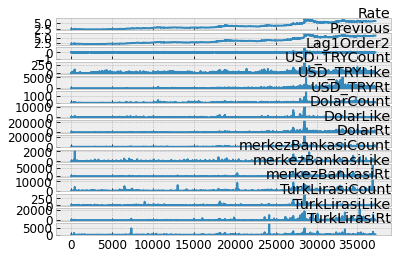

In [12]:
values = exchange_rate.values
groups = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
i = 1
# plot each column
for group in groups:
    plt.subplot(len(groups), 1, i)

    plt.plot(values[:, group])
    plt.title(exchange_rate.columns[group], y=0.5, loc='right')
    i += 1
    

plt.show()

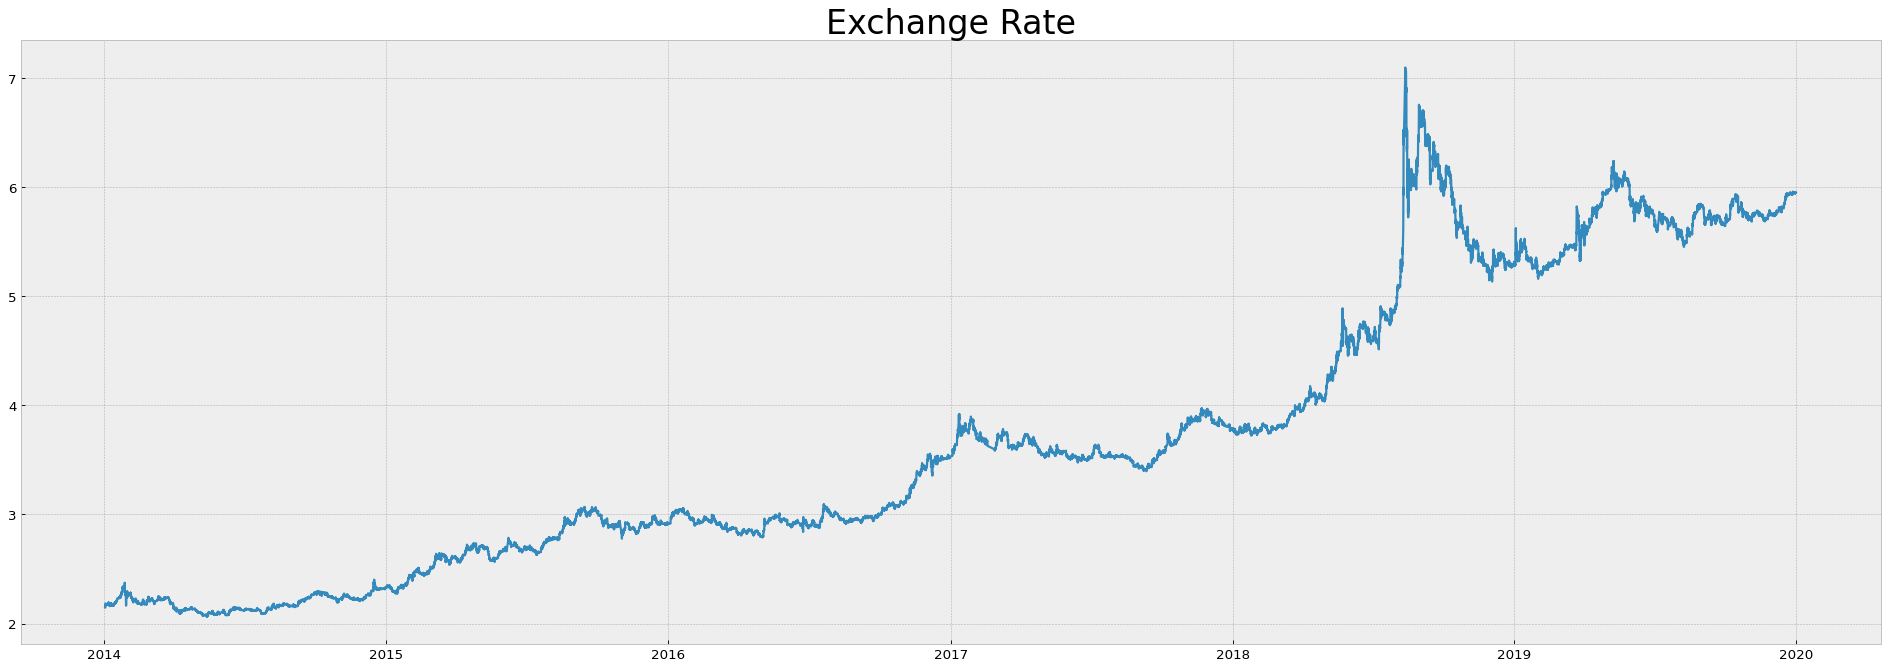

In [13]:
plt.figure(num=None, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='k')
plt.title('Exchange Rate',fontsize=30)

plt.plot(exchange_rate.Rate)
plt.savefig("rate.png")

In [15]:
rcParams['figure.figsize'] = 18, 15
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = exchange_rate.Rate[-6200:]
result = seasonal_decompose(series, model='additive',period=480 )#additive because seasonality’s amplitude is independent of the level , period = 24* 20 (20 trading days per month)
result.plot()
pass

TypeError: ignored

<Figure size 4000x1600 with 0 Axes>

NameError: ignored

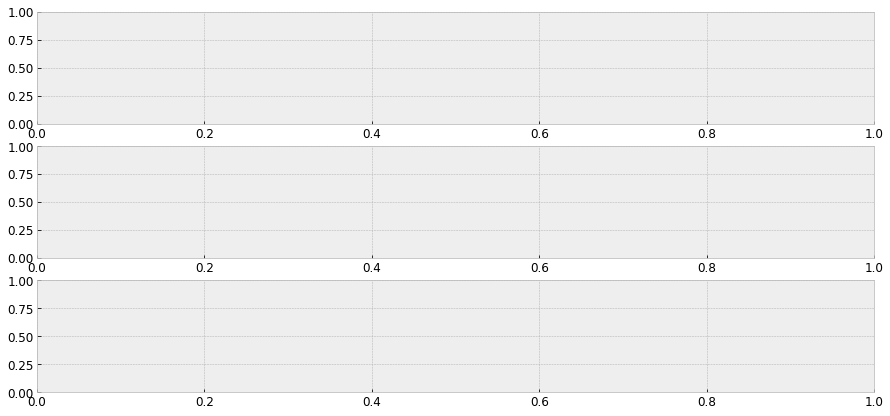

In [10]:

fig = plt.figure(figsize=(15, 7))
layout = (3,2)
pm_ax = plt.subplot2grid(layout, (0,0), colspan=2)
mv_ax = plt.subplot2grid(layout, (1,0), colspan=2)
fit_ax = plt.subplot2grid(layout, (2,0), colspan=2)

pm_ax.plot(result.trend)
pm_ax.set_title("Automatic decomposed trend")

mm = exchange_rate.Rate.rolling(12).mean()
mv_ax.plot(mm)
mv_ax.set_title("Moving average 12 steps")


X = [i for i in range(0, len(exchange_rate.Rate))]
X = np.reshape(X, (len(X), 1))
y = exchange_rate.Rate.values
model = LinearRegression()
model.fit(X, y)
# calculate trend
trend = model.predict(X)
fit_ax.plot(trend)
fit_ax.set_title("Trend fitted by linear regression")

plt.tight_layout()

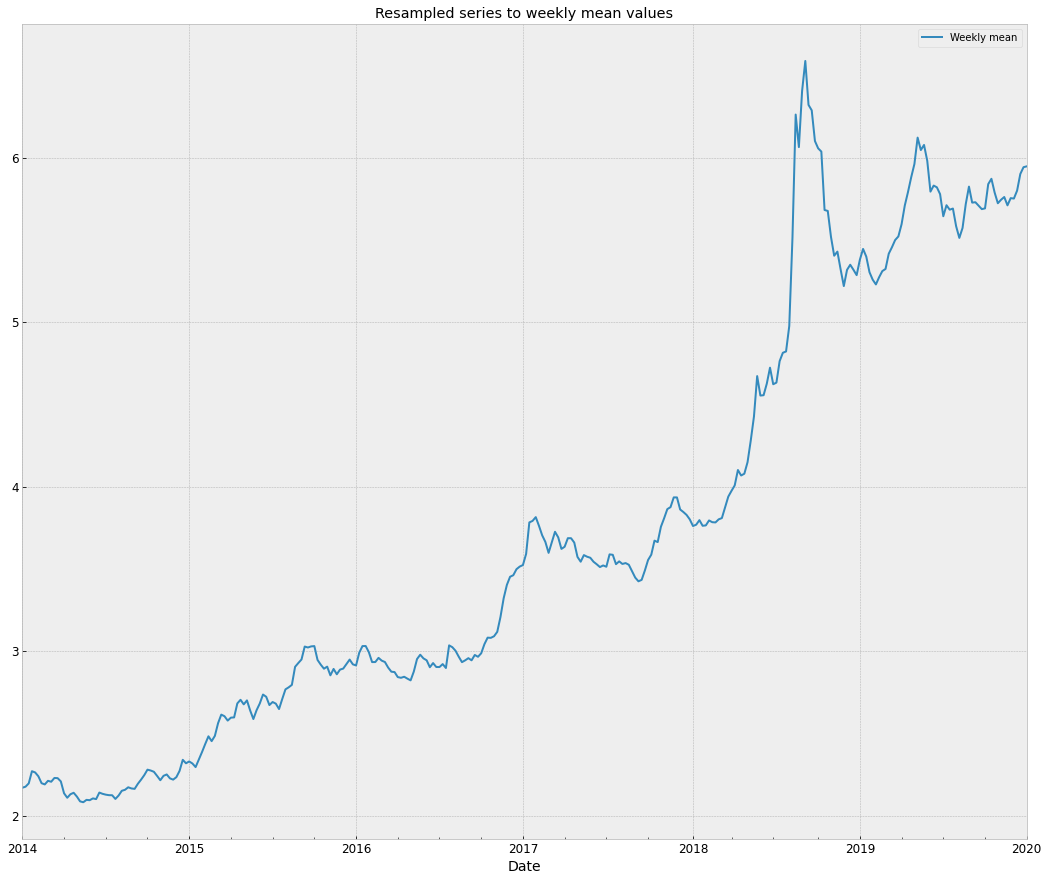

In [16]:
#Looking for weekly seasonality
resample = exchange_rate.resample('W')
weekly_mean = resample.mean()
weekly_mean.Rate.plot(label='Weekly mean')
plt.title("Resampled series to weekly mean values")
plt.legend()

Text(0.5, 1.0, 'Mean over time')

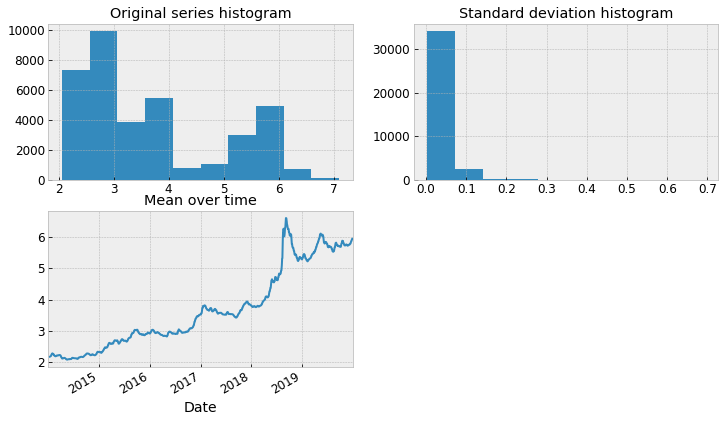

In [ ]:
series = exchange_rate.Rate.values
fig = plt.figure(figsize=(12, 7))
layout = (2,2)
hist_ax = plt.subplot2grid(layout, (0,0))
hist_std_ax = plt.subplot2grid(layout, (0,1))
mean_ax = plt.subplot2grid(layout, (1,0))

exchange_rate.Rate.hist(ax=hist_ax)
hist_ax.set_title("Original series histogram")

mm = exchange_rate.Rate.rolling(168).std()#168 hours at 1 week
mm.hist(ax=hist_std_ax)
hist_std_ax.set_title("Standard deviation histogram")

mm = exchange_rate.Rate.rolling(168).mean()
mm.plot(ax=mean_ax)
mean_ax.set_title("Mean over time")

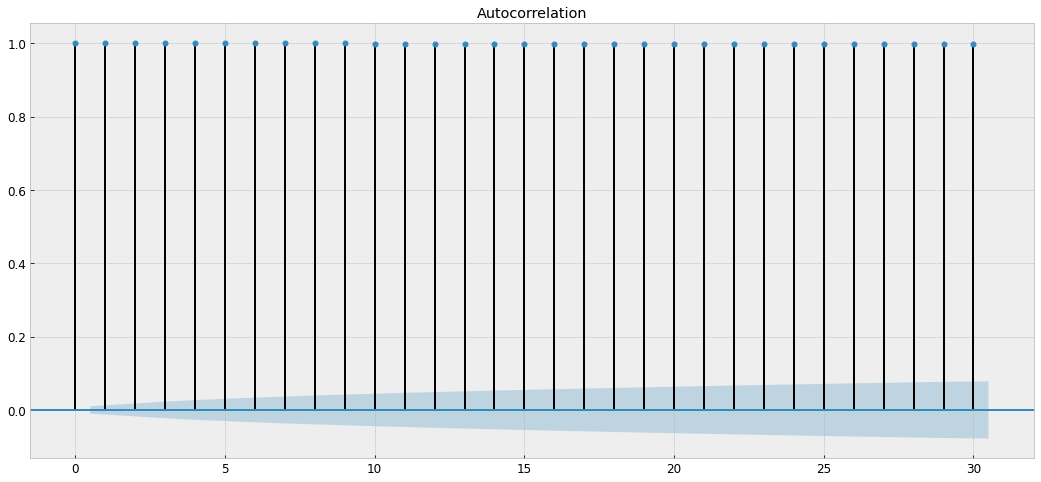

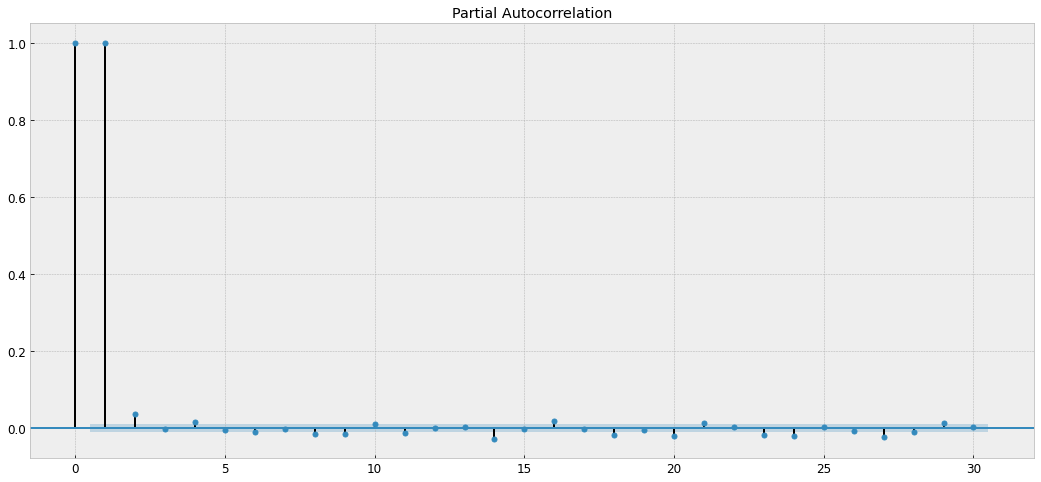

In [ ]:
plot_acf(series, lags = 30)
plot_pacf(series, lags = 30)
plt.show()

Stationary series autocorrelation values will quickly decrease over time t. This shows us that no information is carried over time and then the series should be constant over time. But if we look at our autocorrelation graph it wont decrease over time.
These graphs shows us that our data is not stationary 

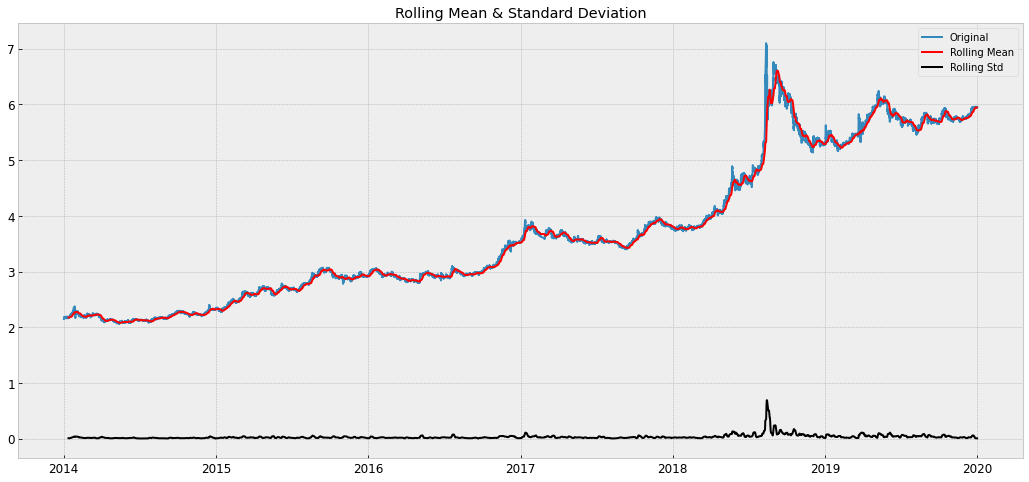

In [ ]:
rolmean = exchange_rate.Rate.rolling(window=168).mean()#168 hours at 1 week
rolstd = exchange_rate.Rate.rolling(window=168).std()

#Plot rolling statistics:
orig = plt.plot(exchange_rate.Rate,label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

Also we can see that our data is not stationary using standart deviation. Mean and standard deviation should be constant over time in order to have a stationary time series.

In [ ]:
X = exchange_rate.Rate.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.238632
p-value: 0.933757
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


**The Augmented Dickey-Fuller test is a type of statistical test called a unit root test. The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend. if p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary**

## Making time series stationary

Applying a difference transform to a time series could help remove the series dependence on time.

This transform is done by substracting the previous obesvation to the current one.

difference(t) = observation(t) - observation(t-1)

In [ ]:
def difference(dataset, interval=1, order=1):
    for u in range(order):
        diff = list()
        for i in range(interval, len(dataset)):
            value = dataset[i] - dataset[i - interval]
            diff.append(value)
        dataset=diff
    return diff

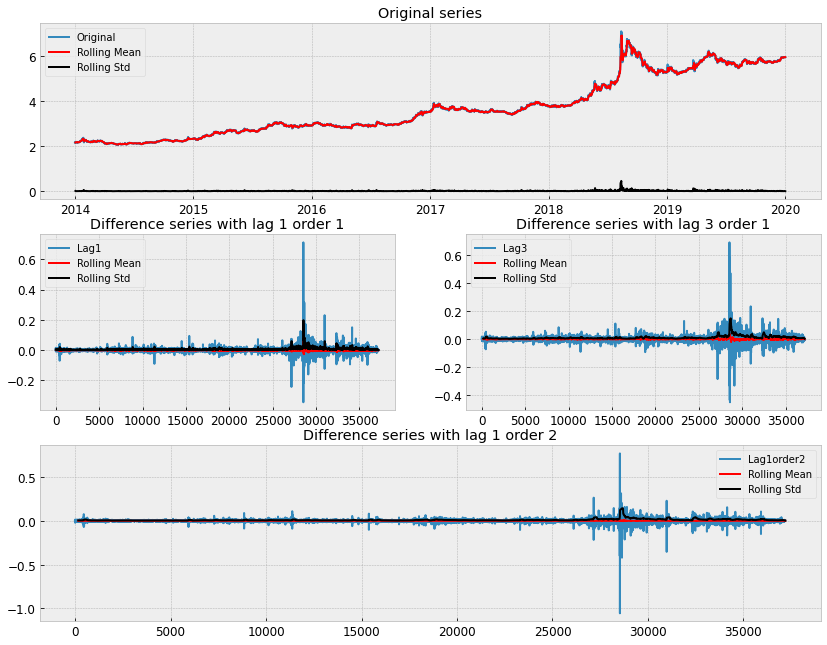

In [ ]:
lag1series = pd.Series(difference(exchange_rate.Rate, interval=1, order=1))
lag3series = pd.Series(difference(exchange_rate.Rate, interval=3, order=1))
lag1order2series = pd.Series(difference(exchange_rate.Rate, interval=1, order=2))

fig = plt.figure(figsize=(14,11))
layout = (3,2)
original = plt.subplot2grid(layout, (0,0), colspan=2)
lag1 = plt.subplot2grid(layout, (1,0))
lag3 = plt.subplot2grid(layout, (1,1))
lag1order2 = plt.subplot2grid(layout, (2,0), colspan=2)

original.set_title('Original series')
original.plot(exchange_rate.Rate, label = 'Original')
original.plot(exchange_rate.Rate.rolling(24).mean(), color='red', label='Rolling Mean')
original.plot(exchange_rate.Rate.rolling(24).std(), color='black', label = 'Rolling Std')
original.legend(loc='best')

lag1.set_title('Difference series with lag 1 order 1')
lag1.plot(lag1series, label = "Lag1")
lag1.plot(lag1series.rolling(24).mean(), color='red', label='Rolling Mean')
lag1.plot(lag1series.rolling(24).std(), color='black', label = 'Rolling Std')
lag1.legend(loc='best')

lag3.set_title('Difference series with lag 3 order 1')
lag3.plot(lag3series, label = "Lag3")
lag3.plot(lag3series.rolling(168).mean(), color='red', label='Rolling Mean')
lag3.plot(lag3series.rolling(168).std(), color='black', label = 'Rolling Std')
lag3.legend(loc='best')

lag1order2.set_title('Difference series with lag 1 order 2')
lag1order2.plot(lag1order2series, label = "Lag1order2")
lag1order2.plot(lag1order2series.rolling(168).mean(), color='red', label='Rolling Mean')
lag1order2.plot(lag1order2series.rolling(168).std(), color='black', label = 'Rolling Std')
lag1order2.legend(loc='best')

In [17]:
resultsDict={}
predictionsDict={}

split_date ='2019-01-01 00:00'
df_training = exchange_rate.loc[exchange_rate.index <= split_date]
df_test = exchange_rate.loc[exchange_rate.index > split_date]
print(f"{len(df_training)} hours of training data \n {len(df_test)} hours of testing data ")


df_training.to_csv('training.csv')
df_test.to_csv('test.csv')


30958 hours of training data 
 6238 hours of testing data 


In [18]:
mean = df_test.Rate.mean()
mean = np.array([mean for u in range(len(df_test))])
resultsDict['Naive mean'] = evaluate(df_test.Rate, mean)
predictionsDict['Naive mean'] = mean
resultsDict['Yesterdays value'] = evaluate(df_test.Rate, df_test.Previous)
predictionsDict['Yesterdays value'] = df_test.Previous.values
predictionsDict['ORIGINAL'] = df_test.Rate.values

**Simple Exponential Smoothing (SES)**

The Simple Exponential Smoothing (SES) method models the next time step as an exponentially weighted linear function of observations at prior time steps. This method expects our time series to be non stationary in order to perform adecuately (no trend or seasonality)

In [19]:
index = len(df_training)
yhat = list()
# Walk throught the test data, training and predicting 1 day ahead for all the test data
for t in tqdm(range(len(df_test.Rate))):
    temp_train = exchange_rate[:len(df_training)+t]
    model = SimpleExpSmoothing(temp_train.Rate)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
resultsDict['SES'] = evaluate(df_test.Rate, yhat.values)
predictionsDict['SES'] = yhat.values

100%|██████████| 6238/6238 [15:17<00:00,  6.80it/s]


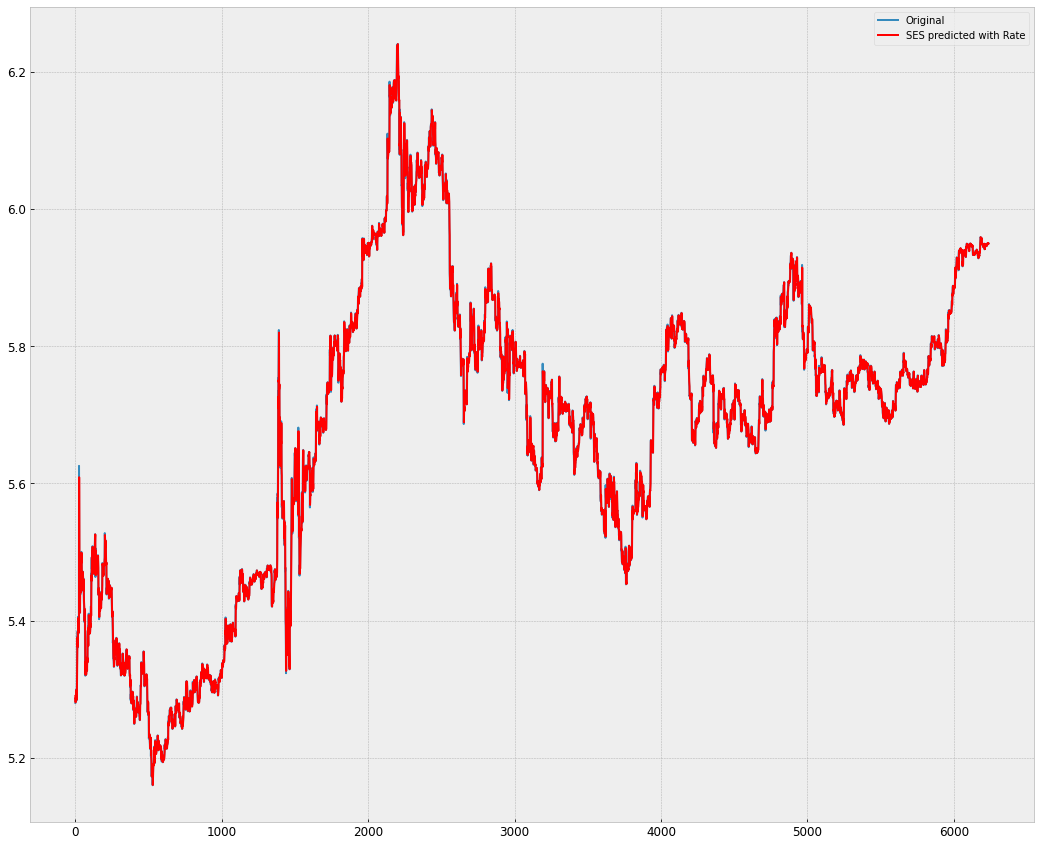

In [20]:
plt.plot(df_test.Rate.values, label='Original')
plt.plot(yhat.values,color='red',label='SES predicted with Rate')
plt.legend()

In [21]:
error = mean_squared_error(df_test.Rate, yhat.values)
print('Test MSE: %.8f' % error)

Test MSE: 0.00012152


In [22]:
index = len(df_training)
yhat = list()
# Walk throught the test data, training and predicting 1 day ahead for all the test data
for t in tqdm(range(len(df_test.Rate))):
    temp_train = exchange_rate[:len(df_training)+t]
    model = ExponentialSmoothing(temp_train.Rate)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
resultsDict['HWES'] = evaluate(df_test.Rate, yhat.values)
predictionsDict['HWES'] = yhat.values

100%|██████████| 6238/6238 [14:47<00:00,  7.03it/s]


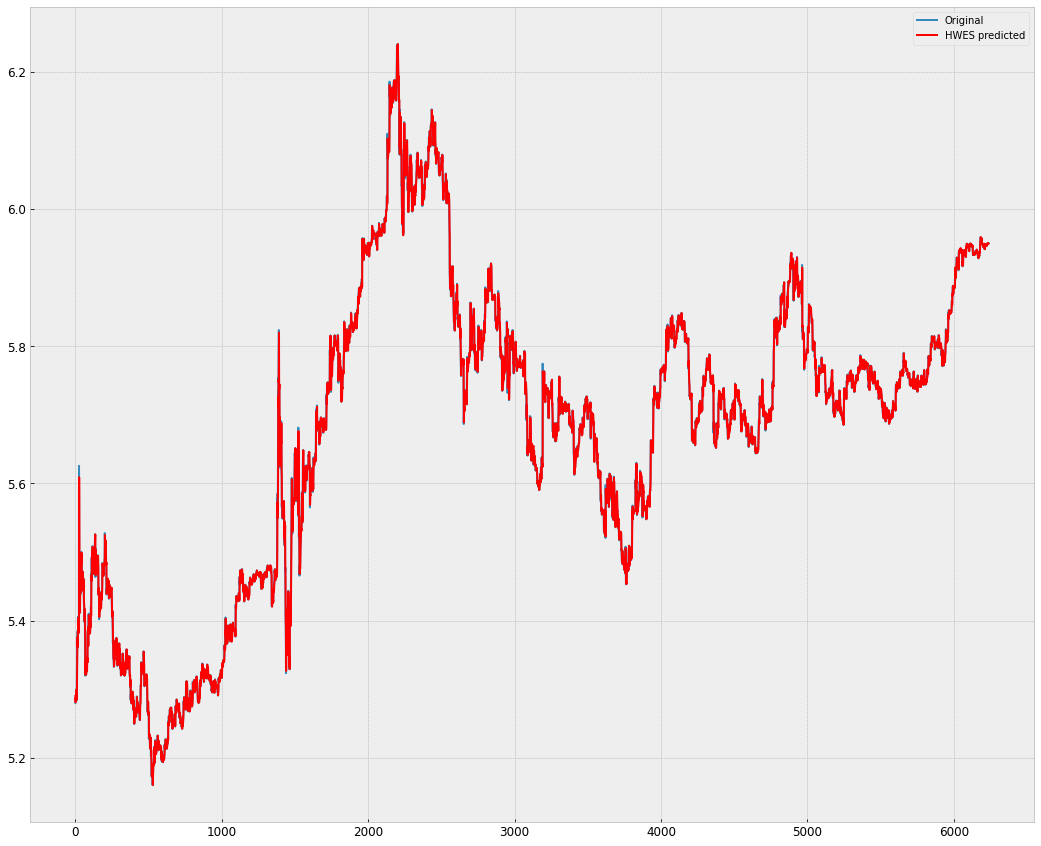

In [23]:
plt.plot(df_test.Rate.values, label='Original')
plt.plot(yhat.values,color='red',label='HWES predicted')
plt.legend()

In [24]:
error = mean_squared_error(df_test.Rate, yhat.values)
print('Test MSE: %.8f' % error)

Test MSE: 0.00012152


In [25]:
index = len(df_training)
yhat = list()
# Walk throught the test data, training and predicting 1 day ahead for all the test data
for t in tqdm(range(len(df_test.Rate))):
    temp_train = exchange_rate[:len(df_training)+t]
    model = AR(temp_train.Rate)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
resultsDict['AR'] = evaluate(df_test.Rate, yhat.values)
predictionsDict['AR'] = yhat.values

100%|██████████| 6238/6238 [38:39<00:00,  2.69it/s]


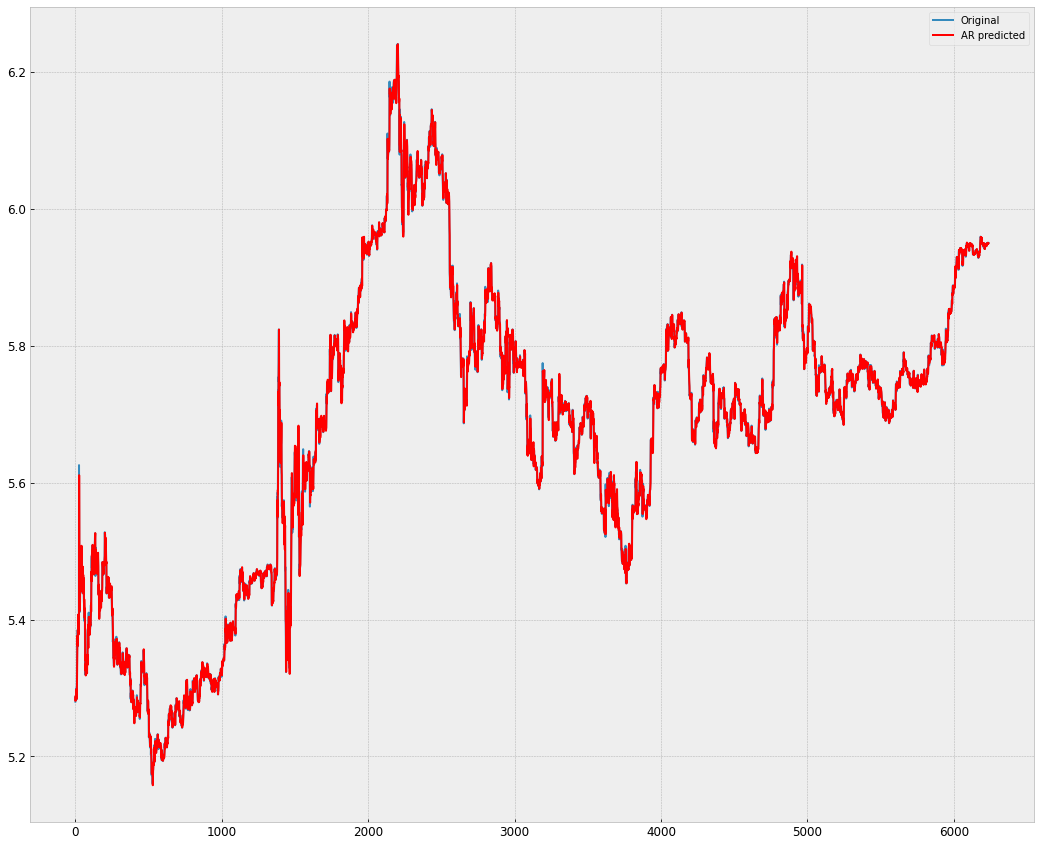

In [26]:
plt.plot(df_test.Rate.values, label='Original')
plt.plot(yhat.values,color='red',label='AR predicted')
plt.legend()

In [27]:
error = mean_squared_error(df_test.Rate, yhat.values)
print('Test MSE: %.8f' % error)

Test MSE: 0.00012517


**Moving Average**

In [28]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

index = len(df_training)
yhat = list()
# Walk throught the test data, training and predicting 1 day ahead for all the test data
for t in tqdm(range(len(df_test.Rate))):
    temp_train = exchange_rate[:len(df_training)+t]
    model = ARIMA(temp_train.Rate,order=(1,0, 0))
    model_fit = model.fit(display = False)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
resultsDict['ARIMA'] = evaluate(df_test.Rate, yhat.values)
predictionsDict['ARIMA'] = yhat.values

100%|██████████| 6238/6238 [2:28:04<00:00,  1.42s/it]


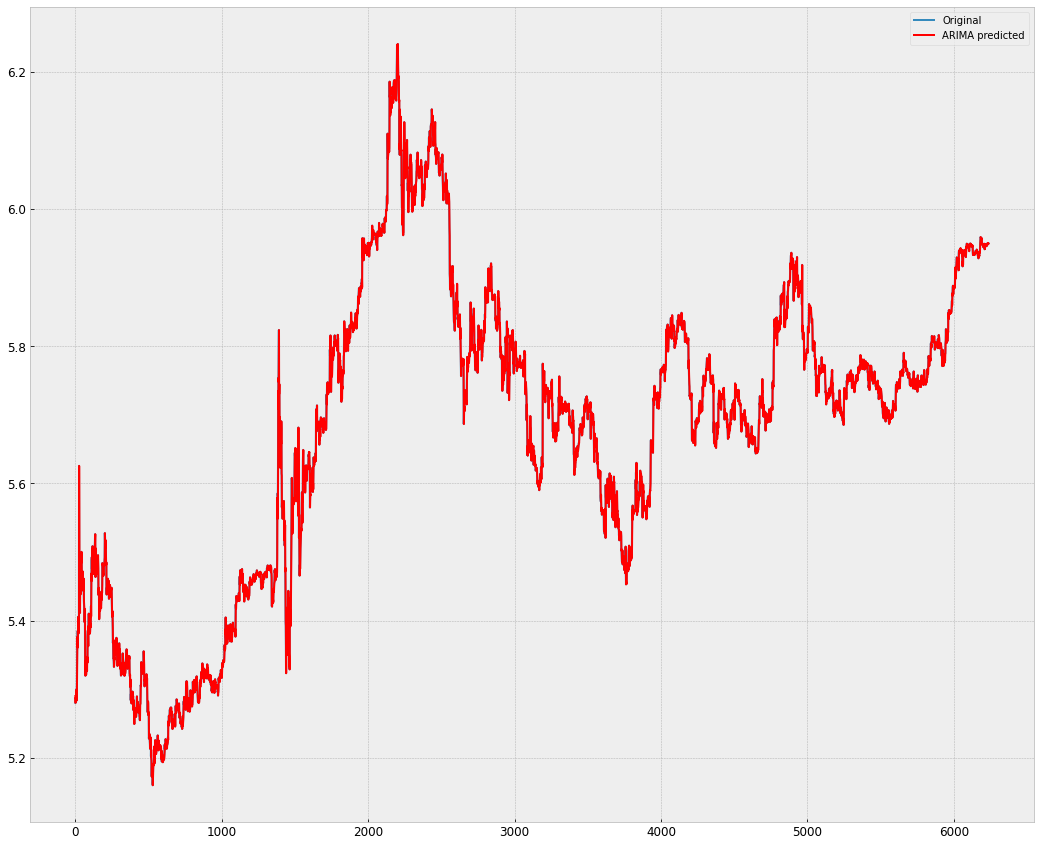

In [29]:
plt.plot(df_test.Rate.values , label='Original')
plt.plot(yhat.values,color='red',label='ARIMA predicted')
plt.legend()

In [30]:
error = mean_squared_error(df_test.Rate, yhat.values)
print('Test MSE: %.8f' % error)

Test MSE: 0.00012238


## Auto ARIMA

In [31]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.Rate))):
    temp_train = exchange_rate[:len(df_training)+t]
    model = SARIMAX(temp_train.Rate, order=(1, 0, 0), seasonal_order=(0, 0, 0, 3))
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
resultsDict['SARIMAX'] = evaluate(df_test.Rate, yhat.values)
predictionsDict['SARIMAX'] = yhat.values

  0%|          | 8/6238 [00:39<8:42:01,  5.03s/it]

KeyboardInterrupt: ignored

In [ ]:
plt.plot(df_test.Rate.values , label='Original')
plt.plot(yhat.values,color='red',label='SARIMAX')
plt.legend()

In [ ]:
error = mean_squared_error(df_test.Rate, yhat.values)
print('Test MSE for SARIMAX: %.8f' % error)

In [32]:
def create_time_features(df,target=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['sin_day'] = np.sin(df['dayofyear'])
    df['cos_day'] = np.cos(df['dayofyear'])
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    X = df.drop(['date'],axis=1)
    if target:
        y = df[target]
        X = X.drop([target],axis=1)
        return X, y
    
    return X

In [33]:
X_train_df, y_train = create_time_features(df_training, target='Rate')
X_test_df, y_test = create_time_features(df_test, target='Rate')
scaler = StandardScaler() 
scaler.fit(X_train_df) 
X_train = scaler.transform(X_train_df)  
X_test = scaler.transform(X_test_df)

X_train_df = pd.DataFrame(X_train,columns=X_train_df.columns)
X_test_df = pd.DataFrame(X_test,columns=X_test_df.columns)

In [34]:
reg = linear_model.BayesianRidge()
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['BayesianRidge'] = evaluate(df_test.Rate, yhat)
predictionsDict['BayesianRidge'] = yhat

Test MSE: 0.00012666


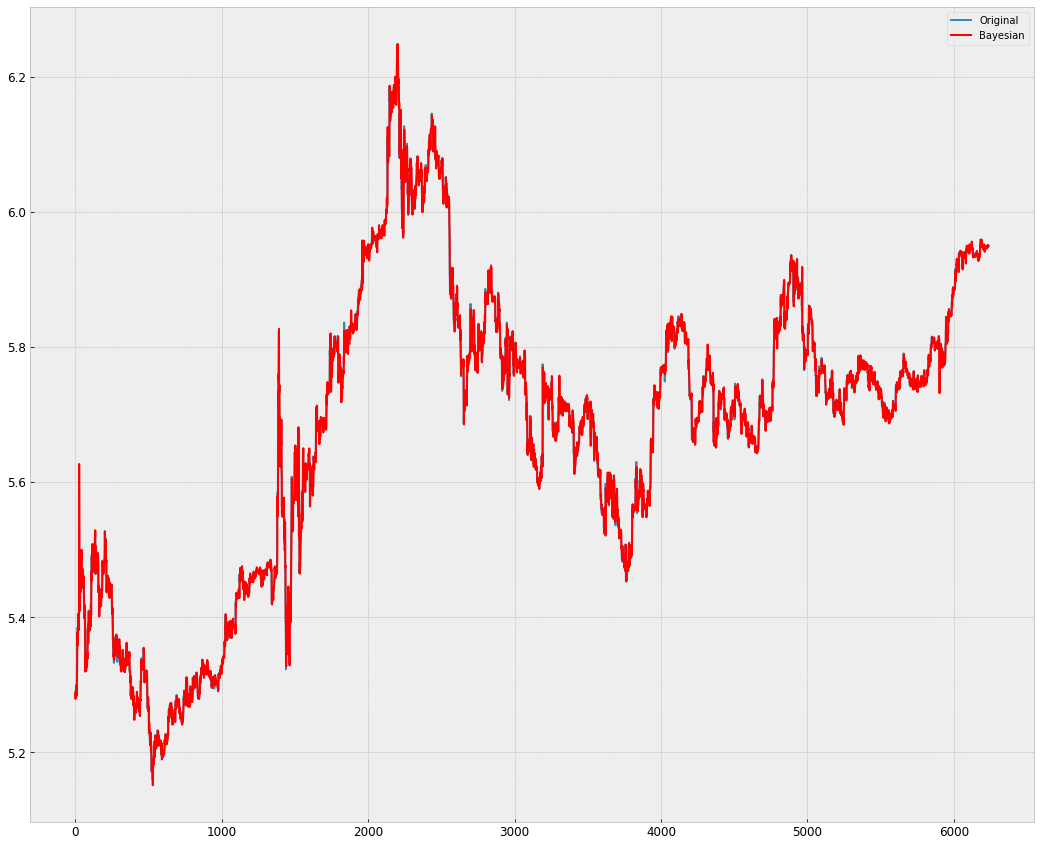

In [35]:
plt.plot(df_test.Rate.values , label='Original')
plt.plot(yhat,color='red',label='Bayesian')
plt.legend()
error = mean_squared_error(df_test.Rate, yhat)
print('Test MSE: %.8f' % error)

In [36]:
reg = linear_model.Lasso(alpha=0.0001) #If alpha value increase, models complexity reduces. So set the alpha value smaller
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['Lasso'] = evaluate(df_test.Rate, yhat)
predictionsDict['Lasso'] = yhat

Test MSE: 0.00012497


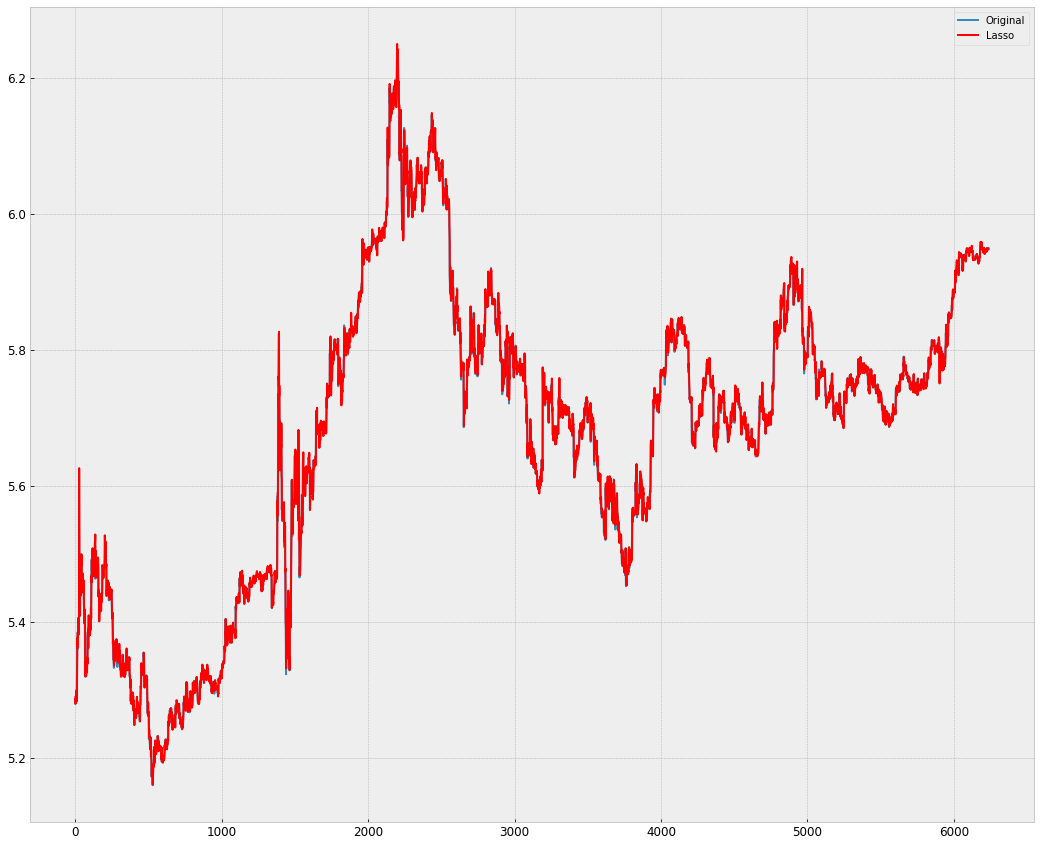

In [37]:
plt.plot(df_test.Rate.values , label='Original')
plt.plot(yhat,color='red',label='Lasso')
plt.legend()
error = mean_squared_error(df_test.Rate, yhat)
print('Test MSE: %.8f' % error)              

Tested alpha values to get a better result.

Minimum alpha value for result is 0.0001. If we choose smaller alpha it didn't changes the MSE.

alpha = 0.01 MSE = 0.0003


In [38]:
reg = RandomForestRegressor(max_depth=16, random_state=0)  #set higher max_depth because it represents depth of each tree in the forest 
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['Randomforest'] = evaluate(df_test.Rate, yhat)
predictionsDict['Randomforest'] = yhat

Test MSE: 0.00059458


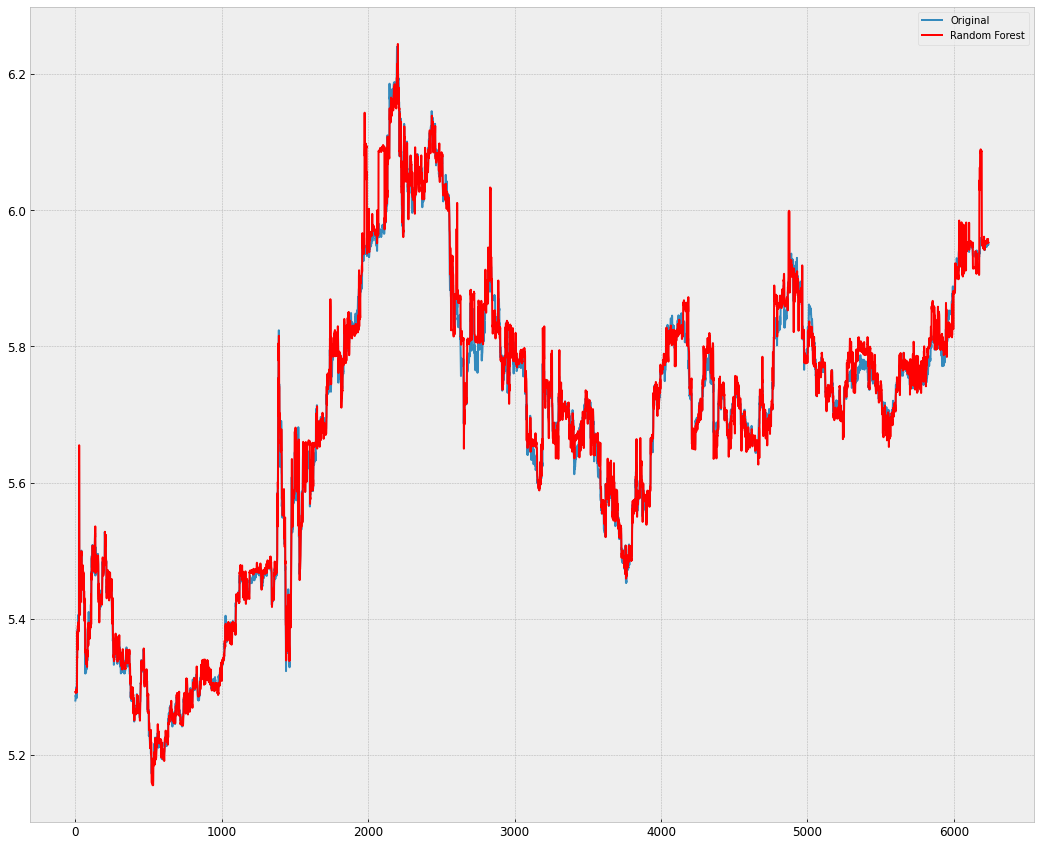

In [39]:
plt.plot(df_test.Rate.values , label='Original')
plt.plot(yhat,color='red',label='Random Forest')
plt.legend()
error = mean_squared_error(df_test.Rate, yhat)
print('Test MSE: %.8f' % error)

depth = 8 MSE = 0.00003

depth = 16 MSE = 0.00002

depth = 32 MSE = 0.00002

So the optimal depth for this model should be 16

In [40]:
reg = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=300, max_depth=5)
reg.fit(X_train, y_train,
       verbose=False) # Change verbose to True if you want to see it train
yhat = reg.predict(X_test)
resultsDict['XGBoost'] = evaluate(df_test.Rate, yhat)
predictionsDict['XGBoost'] = yhat

Test MSE: 0.00051453


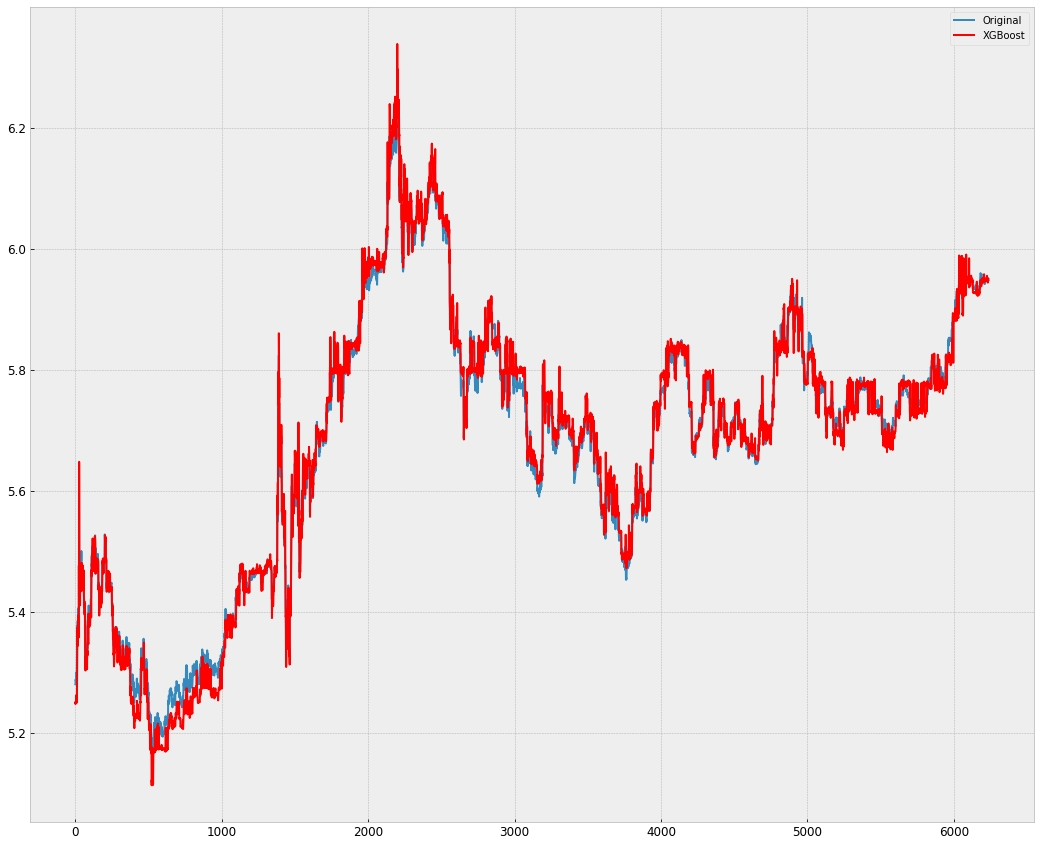

In [41]:
plt.plot(df_test.Rate.values , label='Original')
plt.plot(yhat,color='red',label='XGBoost')
plt.legend()
error = mean_squared_error(df_test.Rate, yhat)
print('Test MSE: %.8f' % error)

300 estimator and 5 depth = 0.00002

1000 estimators and default depth = 0.00010

In [42]:
lightGBM = lgb.LGBMRegressor()
lightGBM.fit(X_train,y_train)
yhat = lightGBM.predict(X_test)
resultsDict['Lightgbm'] = evaluate(df_test.Rate, yhat)
predictionsDict['Lightgbm'] = yhat

Test MSE: 0.03106811


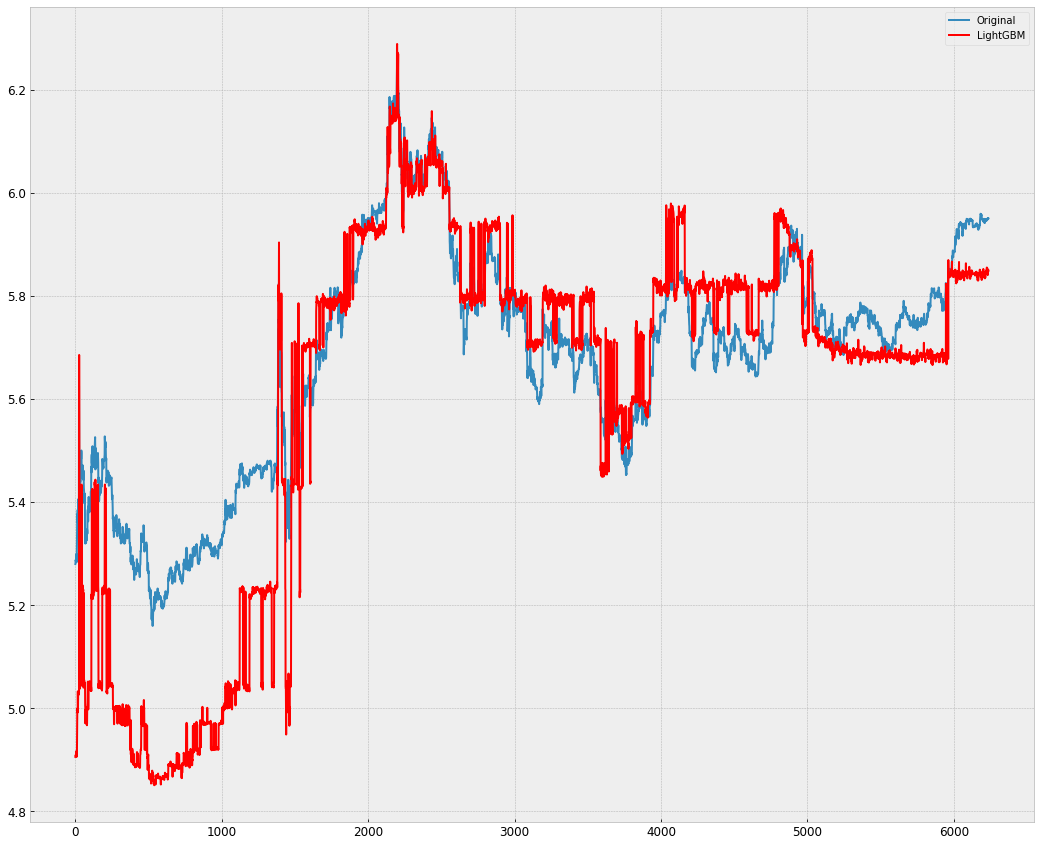

In [43]:
plt.plot(df_test.Rate.values , label='Original')
plt.plot(yhat,color='red',label='LightGBM')
plt.legend()
error = mean_squared_error(df_test.Rate, yhat)
print('Test MSE: %.8f' % error)

In [44]:
BATCH_SIZE = 128
BUFFER_SIZE = 50
WINDOW_LENGTH = 24
def window_data(X,Y,window=24):
    '''
    The dataset length will be reduced to guarante all samples have the window, so new length will be len(dataset)-window
    '''
    x=[]
    y=[]
    for i in range(window-1,len(X)):
        x.append(X[i-window+1:i+1]) 
        y.append(Y[i])
    return np.array(x), np.array(y)
        
#Since we are doing sliding, we need to join the datasets again of train and test
X_w = np.concatenate((X_train, X_test))
y_w = np.concatenate((y_train, y_test))

X_w,y_w = window_data(X_w,y_w,window=WINDOW_LENGTH)
X_train_w = X_w[:-len(X_test)]
y_train_w = y_w[:-len(X_test)]
X_test_w = X_w[-len(X_test):]
y_test_w = y_w[-len(X_test):]

#Check we will have same test set as in the previous models, make sure we didnt screw up on the windowing
print(f"Test set equal: {np.array_equal(y_test_w,y_test)}")

train_data = tf.data.Dataset.from_tensor_slices((X_train_w, y_train_w))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((X_test_w, y_test_w))
val_data = val_data.batch(BATCH_SIZE).repeat()

Test set equal: True


In [45]:
dropout=0.0
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, input_shape=X_train_w.shape[-2:],dropout=dropout),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='rmsprop', loss='mae')

In [54]:
EVALUATION_INTERVAL = len(X_train) / BATCH_SIZE
EPOCHS = 150

model_history = simple_lstm_model.fit(train_data, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_data, validation_steps=20)

Epoch 1/150
241/241 [==============================] - 3s 11ms/step - loss: 0.0401 - val_loss: 0.0591
Epoch 2/150
241/241 [==============================] - 3s 11ms/step - loss: 0.0397 - val_loss: 0.1380
Epoch 3/150
241/241 [==============================] - 3s 11ms/step - loss: 0.0390 - val_loss: 0.1294
Epoch 4/150
241/241 [==============================] - 3s 11ms/step - loss: 0.0399 - val_loss: 0.0533
Epoch 5/150
241/241 [==============================] - 3s 11ms/step - loss: 0.0400 - val_loss: 0.0472
Epoch 6/150
241/241 [==============================] - 3s 11ms/step - loss: 0.0395 - val_loss: 0.0483
Epoch 7/150
241/241 [==============================] - 3s 11ms/step - loss: 0.0394 - val_loss: 0.1294
Epoch 8/150
241/241 [==============================] - 3s 11ms/step - loss: 0.0389 - val_loss: 0.1240
Epoch 9/150
241/241 [==============================] - 2s 10ms/step - loss: 0.0392 - val_loss: 0.1182
Epoch 10/150
241/241 [==============================] - 3s 10ms/step - loss: 0.038

In [55]:
yhat = simple_lstm_model.predict(X_test_w).reshape(1,-1)[0]
resultsDict['Tensorflow simple LSTM'] = evaluate(y_test,yhat)
predictionsDict['Tensorflow simple LSTM'] = yhat

Test MSE: 0.00334119


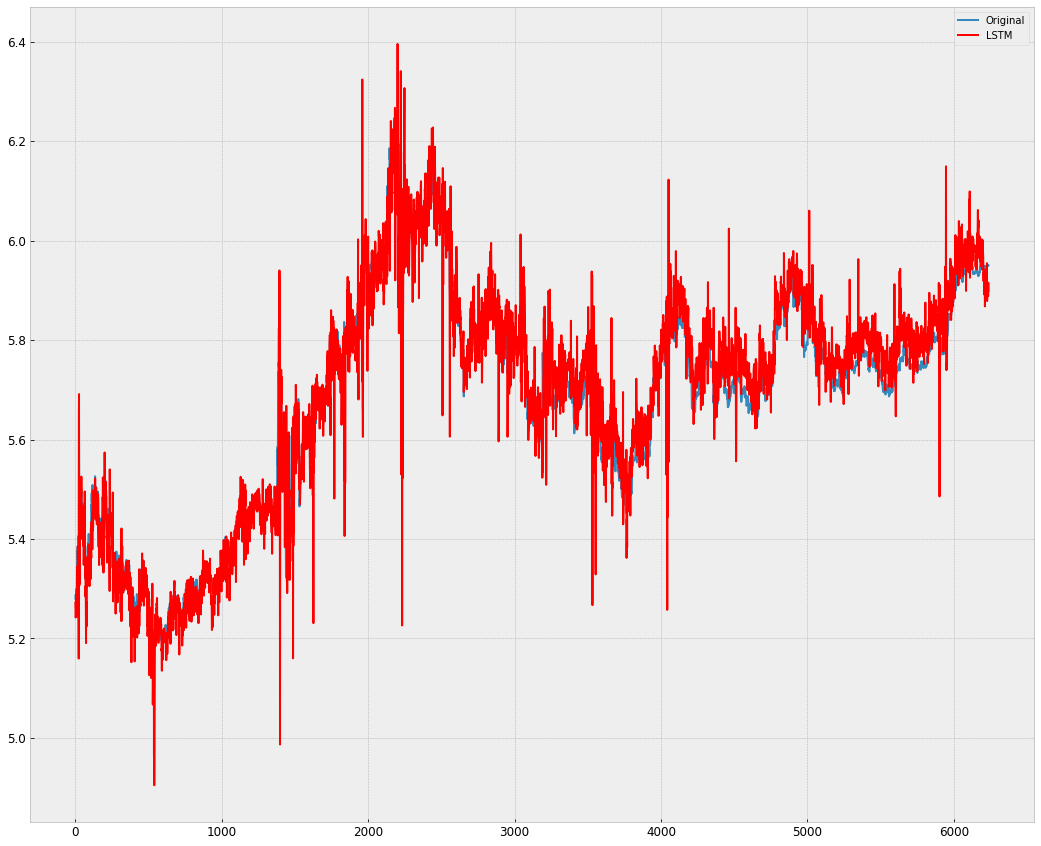

In [56]:
plt.plot(df_test.Rate.values , label='Original')
plt.plot(yhat,color='red',label='LSTM')
plt.legend()
error = mean_squared_error(df_test.Rate, yhat)
print('Test MSE: %.8f' % error)

BATCH_SIZE = 64
BUFFER_SIZE = 100
WINDOW_LENGTH = 24
Window = 168
Result = 2.5

BATCH_SIZE = 512
BUFFER_SIZE = 1000
WINDOW_LENGTH = 120
Window = 120
Result = 0.8

BATCH_SIZE = 128
BUFFER_SIZE = 1000
WINDOW_LENGTH = 120
Window = 120
Result = 4.5

BATCH_SIZE = 128
BUFFER_SIZE = 100
WINDOW_LENGTH = 24
window = 120
Result = 0.13

BATCH_SIZE = 128
BUFFER_SIZE = 50
WINDOW_LENGTH = 24
window = 24
Epoch = 50
Result = 0.03

In [57]:
features = ['Previous', 'Lag1Order2', 'hour', 'USD_TRYCount', 'USD_TRYLike', 'USD_TRYRt',
            'DolarCount', 'DolarLike', 'DolarRt', 'merkezBankasiCount', 'merkezBankasiLike', 'merkezBankasiRt',
            'TurkLirasiCount', 'TurkLirasiLike', 'TurkLirasiRt','dayofweek', 'quarter', 'month',
            'year', 'dayofyear', 'sin_day', 'cos_day', 'dayofmonth', 'weekofyear']

scaler = StandardScaler() 
scaler.fit(X_train) #No cheating, never scale on the training+test!
df_training[features] = scaler.transform(df_training[features])  
df_test[features] = scaler.transform(df_test[features])


training_data = ListDataset(
    [{"start": df_training.index[0], "target": df_training.Rate,
      'feat_dynamic_real': [df_training[feature] for feature in features]
      }],
    freq="d"
)
test_data = ListDataset(
    [{"start": df_test.index[0], "target": df_test.Rate,
      'feat_dynamic_real': [df_test[feature] for feature in features]
      }],
    freq="d"
)

In [58]:
estimator = DeepAREstimator(freq="d",
                            prediction_length=1
                            , context_length=10,
                            trainer=Trainer(epochs=20))

predictor = estimator.train(training_data=training_data)





forecast_it, ts_it = make_evaluation_predictions(test_data, predictor=predictor, num_samples=len(df_test))

forecasts = list(forecast_it)
tss = list(ts_it)


  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:05<00:00,  8.69it/s, epoch=1/20, avg_epoch_loss=0.558]

100%|██████████| 50/50 [00:05<00:00,  8.80it/s, epoch=2/20, avg_epoch_loss=-.832]

100%|██████████| 50/50 [00:05<00:00,  9.13it/s, epoch=3/20, avg_epoch_loss=-.951]

100%|██████████| 50/50 [00:05<00:00,  8.87it/s, epoch=4/20, avg_epoch_loss=-1.17]

100%|██████████| 50/50 [00:05<00:00,  9.06it/s, epoch=5/20, avg_epoch_loss=-1.15]

100%|██████████| 50/50 [00:05<00:00,  9.08it/s, epoch=6/20, avg_epoch_loss=-1.51]

100%|██████████| 50/50 [00:05<00:00,  8.85it/s, epoch=7/20, avg_epoch_loss=-1.62]

100%|██████████| 50/50 [00:05<00:00,  9.06it/s, epoch=8/20, avg_epoch_loss=-1.63]

100%|██████████| 50/50 [00:05<00:00,  8.99it/s, epoch=9/20, avg_epoch_loss=-1.75]

100%|██████████| 50/50 [00:05<00:00,  8.78it/s, epoch=10/20, avg_epoch_loss=-1.79]

100%|██████████| 50/50 [00:05<00:00,  8.90it/s, epoch=11/20, avg_epoch_loss=-1.85]

100%|██████████| 50/50 [00:05<00:00,  9.29it/s, epoch=12/20, avg_epoch_loss=-1.82]

1

In [59]:
yhat = forecasts[0].samples.reshape(1,-1)[0]
resultsDict['DeepAR'] = evaluate(y_test,yhat)
predictionsDict['DeepAR'] = yhat

Test MSE: 0.14879762


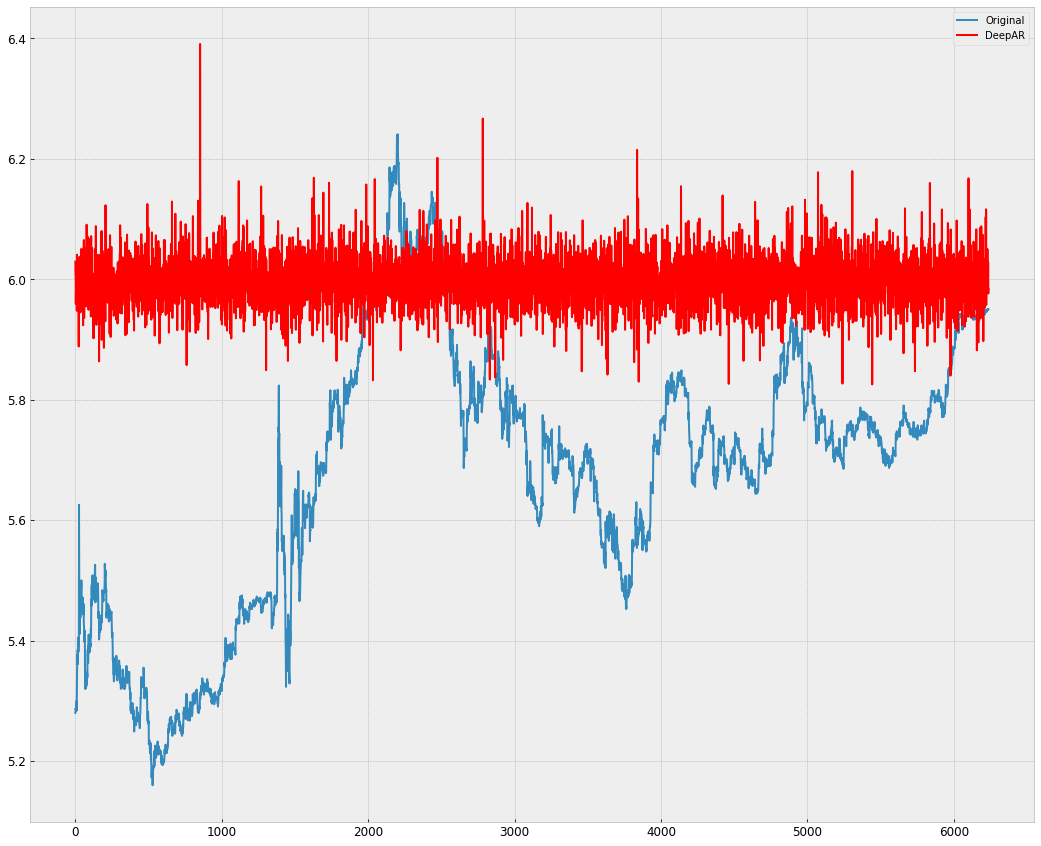

In [60]:
plt.plot(df_test.Rate.values , label='Original')
plt.plot(yhat,color='red',label='DeepAR')
plt.legend()
error = mean_squared_error(df_test.Rate, yhat)
print('Test MSE: %.8f' % error)

prediction_length=1
context_length=30,
trainer=Trainer(epochs=5)
Result = 0.21

context_length=20,
trainer=Trainer(epochs=50)
result = 0.006

context_length=20,
trainer=Trainer(epochs=10)
Result = 0.005

context_length=40,
trainer=Trainer(epochs=10)
Result = 0.030

context_length=20,
trainer=Trainer(epochs=20)
Result = 0.003

# **ENSEMBLING**

In [61]:
models = ['Tensorflow simple LSTM',
 'Lightgbm',
 'XGBoost']
resis = pd.DataFrame(data={k: df_test.Rate.values - v for k, v in predictionsDict.items()})[models]
corr = resis.corr()
print("Residuals correlation")
corr.style.background_gradient(cmap='coolwarm')

Residuals correlation


,Tensorflow simple LSTM,Lightgbm,XGBoost
Tensorflow simple LSTM,1.000000,0.208335,0.031652
Lightgbm,0.208335,1.000000,0.521168
XGBoost,0.031652,0.521168,1.000000


In [62]:
predictionsDict['EnsembleXG+LIGHT'] = (predictionsDict['XGBoost'] + predictionsDict['Lightgbm'])/2
resultsDict['EnsembleXG+LIGHT'] = evaluate(df_test.Rate.values,predictionsDict['EnsembleXG+LIGHT'])

predictionsDict['EnsembleXG+LIGHT+TF'] = (predictionsDict['XGBoost'] + predictionsDict['Lightgbm']+ predictionsDict['Tensorflow simple LSTM'])/3
resultsDict['EnsembleXG+LIGHT+TF'] = evaluate(df_test.Rate.values,predictionsDict['EnsembleXG+LIGHT+TF'])

predictionsDict['EnsembleLIGHT+TF'] = (predictionsDict['Lightgbm']+ predictionsDict['Tensorflow simple LSTM'])/2
resultsDict['EnsembleLIGHT+TF'] = evaluate(df_test.Rate.values,predictionsDict['EnsembleLIGHT+TF'])

predictionsDict['EnsembleXG+TF'] = (predictionsDict['XGBoost']+ predictionsDict['Tensorflow simple LSTM'])/2
resultsDict['EnsembleXG+TF'] = evaluate(df_test.Rate.values,predictionsDict['EnsembleXG+TF'])

In [63]:
import pickle

with open('scores.pickle', 'wb') as handle:
    pickle.dump(resultsDict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('predictions.pickle', 'wb') as handle:
    pickle.dump(predictionsDict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [64]:
from google.colab import files
files.download('scores.pickle')
files.download('predictions.pickle')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>